Loading model...
Loading scaler...


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

======= SPECIFIC TIMESTAMP =======
Timestamp: 2025-11-18 02:00:00
Predicted: 696.6767133876145
Actual:    903.27



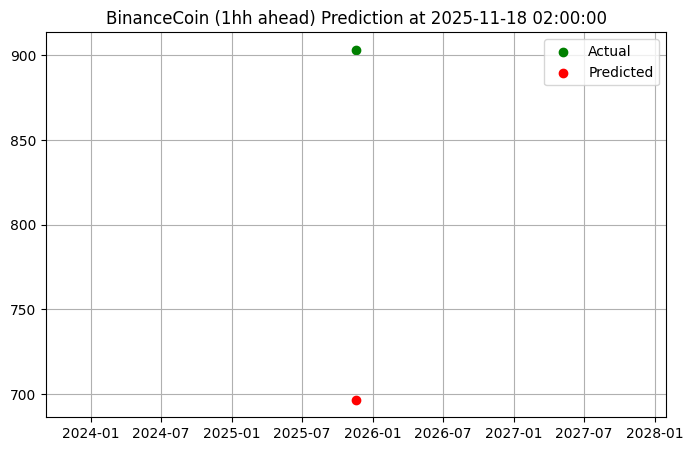

In [11]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

# ================================
# USER SETTINGS
# ================================

COIN_NAME = "BinanceCoin"
HORIZON = "1h"        # "1h" / "12h" / "24h" / "48h"

BASE_DIR = "/Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025"

MODEL_PATH  = f"{BASE_DIR}/Milestone_2/model/{COIN_NAME}/lstm_{COIN_NAME}_{HORIZON}_final.keras"
SCALER_PATH = f"{BASE_DIR}/Milestone_1/data/processed/{COIN_NAME}_scaler.pkl"
CSV_PATH    = f"{BASE_DIR}/Milestone_1/data/processed/{COIN_NAME}_processed.csv"
SEQ_PATH = f"{BASE_DIR}/Milestone_1/data/sequences/{COIN_NAME}/{HORIZON}/"

SEQ_LEN = 48

# ================================
# LOAD MODEL & SCALER
# ================================


print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)

print("Loading scaler...")
scaler = joblib.load(SCALER_PATH)
# ================================
# LOAD DATAFRAME
# ================================

df = pd.read_csv(CSV_PATH, parse_dates=["open_time"])
df = df.set_index("open_time")

feature_cols = [
    "open","high","low","close","volume",
    "return_1h","volatility_24h",
    "ma_24","ma_168","ma_ratio",
    "vol_change","missing_flag"
]

# ================================
# FIND THE INDEX OF THE TIMESTAMP
# ================================

if TIMESTAMP not in df.index:
    raise ValueError("Timestamp not found in dataset!")

idx = df.index.get_loc(TIMESTAMP)

# ensure we have 48 hours before it
H = int(HORIZON.replace("h", ""))
if idx < SEQ_LEN + H:
    raise ValueError("Not enough historical data before this timestamp.")

# ================================
# BUILD INPUT WINDOW
# ================================

start = idx - SEQ_LEN - H
end   = start + SEQ_LEN

window = df[feature_cols].iloc[start:end].values
window = window.reshape(1, SEQ_LEN, len(feature_cols))

# ================================
# MAKE PREDICTION (scaled)
# ================================

scaled_pred = model.predict(window)[0][0]

# inverse scale
dummy = np.zeros((1, len(feature_cols)))
dummy[0][feature_cols.index("close")] = scaled_pred
predicted_price = scaler.inverse_transform(dummy)[0][feature_cols.index("close")]

# ================================
# GET ACTUAL VALUE
# ================================

actual_time = df.index[idx]
actual_close_scaled = df["close"].iloc[idx]
dummy2 = np.zeros((1, len(feature_cols)))
dummy2[0][feature_cols.index("close")] = actual_close_scaled
actual_price = scaler.inverse_transform(dummy2)[0][feature_cols.index("close")]

# ================================
# PRINT RESULTS
# ================================

print("\n======= SPECIFIC TIMESTAMP =======")
print(f"Timestamp: {actual_time}")
print(f"Predicted: {predicted_price}")
print(f"Actual:    {actual_price}")
print("=================================\n")

# ================================
# OPTIONAL: plot
# ================================

plt.figure(figsize=(8,5))
plt.scatter([actual_time], [actual_price], color="green", label="Actual")
plt.scatter([actual_time], [predicted_price], color="red", label="Predicted")
plt.title(f"{COIN_NAME} ({HORIZON}h ahead) Prediction at {TIMESTAMP}")
plt.legend()
plt.grid(True)
plt.show()